In [62]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

In [63]:
img1 = cv.imread('Photos/want1.jpg')
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)

img2 = cv.imread('Photos/want4.jpg')
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

Text(0.5, 1.0, 'Scanned')

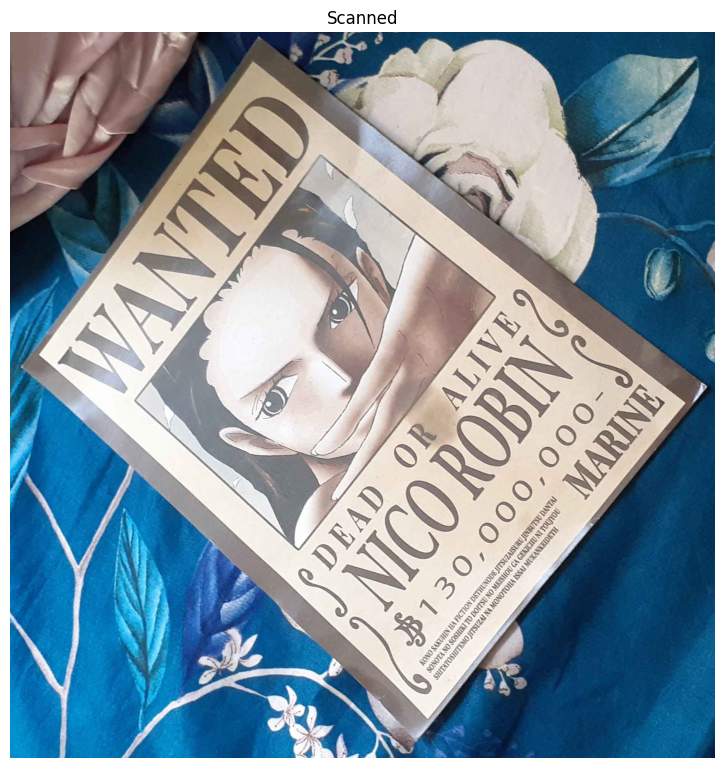

In [64]:
plt.figure(figsize=[20,10])
plt.subplot(121);plt.axis('off');plt.imshow(img1);plt.title('Original')
plt.subplot(121);plt.axis('off');plt.imshow(img2);plt.title('Scanned')

In [65]:
img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img2_gray = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

# MAX_NUM_FEATURE = 50000 #Only require for orb
sift = cv.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

img1_display = cv.drawKeypoints(img1, keypoints1, outImage=np.array([]), color=(255,0,0),flags=cv.DRAW_MATCHES_FLAGS_DEFAULT)
img2_display = cv.drawKeypoints(img2, keypoints2, outImage=np.array([]), color=(255,0,0),flags=cv.DRAW_MATCHES_FLAGS_DEFAULT)

Text(0.5, 1.0, 'Original')

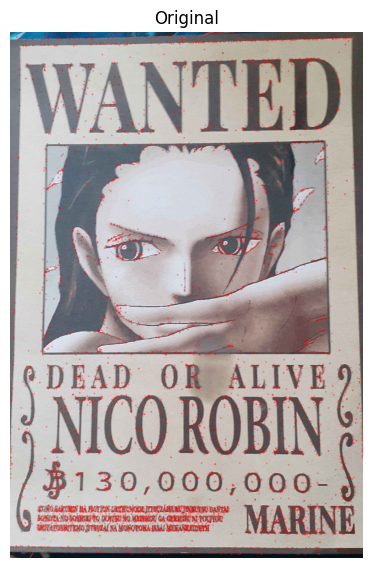

In [66]:
plt.figure(figsize=[10,10])
plt.subplot(121);plt.axis('off');plt.imshow(img1_display);plt.title('Original')

Text(0.5, 1.0, 'Scanned')

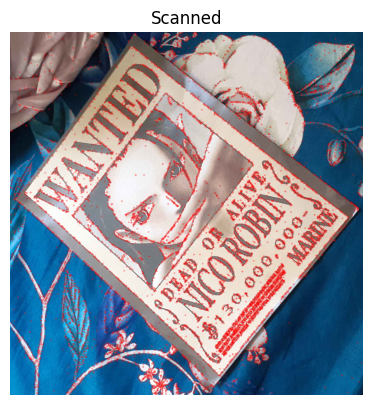

In [67]:
plt.figure(figsize=[10,10])
plt.subplot(121);plt.axis('off');plt.imshow(img2_display);plt.title('Scanned')

In [68]:
#Match for orb
# matcher = cv.DescriptorMatcher_create(cv.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
# matches = matcher.match(descriptors1, descriptors2, None)

#sort
# list(matches).sort(key=lambda x: x.distance, reverse=False)

# numsGoodMatches = int(len(matches)*0.1)
# matches = matches[:numsGoodMatches]

# KNN Match
matcher = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
matches = matcher.knnMatch(descriptors1, descriptors2, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance: # lowe's ratio test
        good_matches.append(m)

print(f"Number of good matches: {len(good_matches)}")

Number of good matches: 813


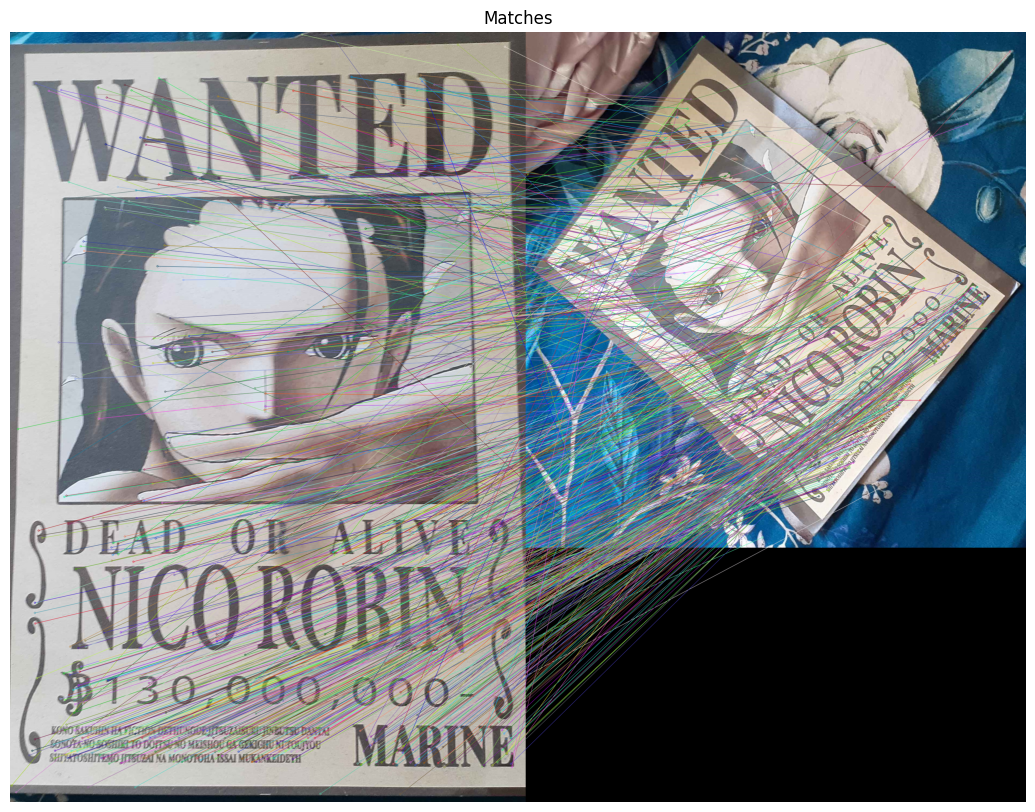

In [69]:
#Draw
im_matches = cv.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=[40,10])
plt.imshow(im_matches);plt.axis('off');plt.title('Matches');

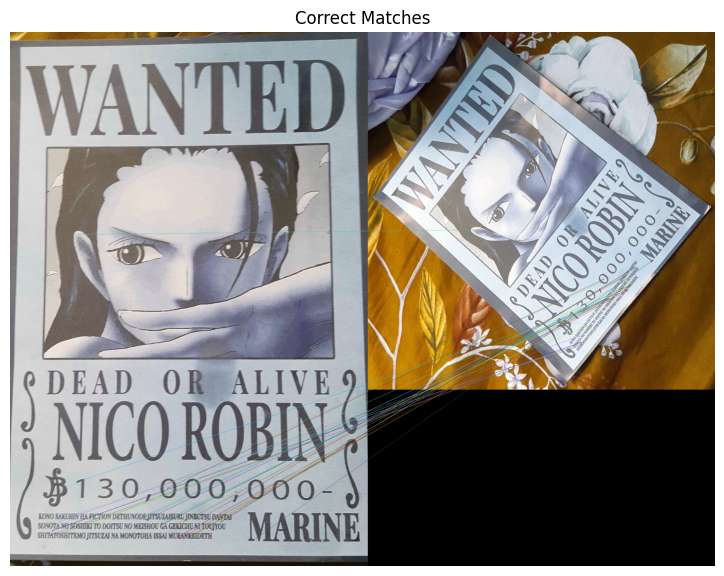

M:[[ 1.14882815e+00 -1.32741220e+00  1.11159998e+03]
 [ 1.42487933e+00  1.09988593e+00 -9.12229066e+02]
 [-9.31222696e-06 -2.45397575e-05  1.00000000e+00]]


In [70]:
# Shortcut for the 2 steps below
# p1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
# p2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

p1 = np.zeros((len(good_matches), 2), dtype=np.float32)
p2 = np.zeros((len(good_matches), 2), dtype=np.float32)

for i, match in enumerate(good_matches):
    p1[i,:] = keypoints1[match.queryIdx].pt
    p2[i,:] = keypoints2[match.trainIdx].pt

# Homography
M, mask = cv.findHomography(p2,p1,cv.RANSAC, 0.8)

matches_mask = mask.ravel().tolist()
inlier_matches = [good_matches[i] for i in range(len(good_matches)) if matches_mask[i]]
inlier_img = cv.drawMatches(img1, keypoints1, img2, keypoints2, inlier_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=[20, 10])
plt.subplot(121);plt.axis('off');plt.imshow(cv.cvtColor(inlier_img, cv.COLOR_BGR2RGB));plt.title('Correct Matches')
plt.show()

# inspecting M
print(f'M:{M}')

Text(0.5, 1.0, 'Scanned')

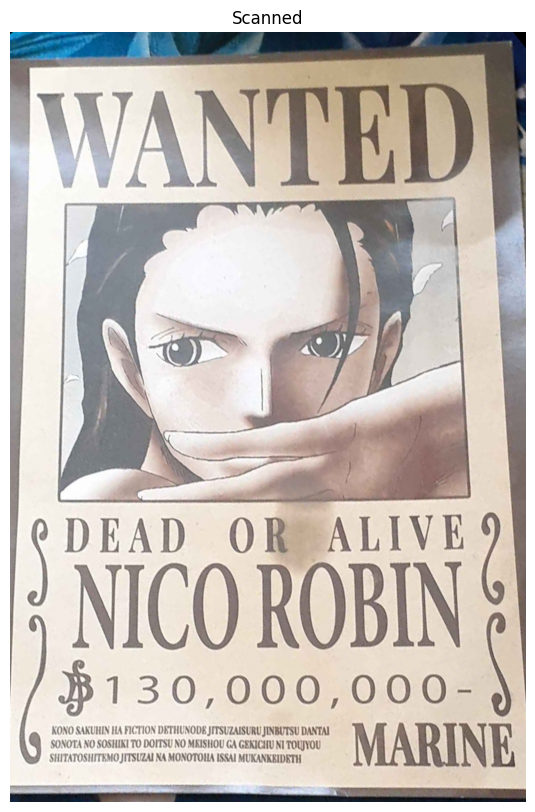

In [71]:
#wrap img
height, width, channels = img1.shape
img2_reg = cv.warpPerspective(img2, M, (width, height))

plt.figure(figsize=[20,10])
plt.subplot(121);plt.axis('off');plt.imshow(img2_reg);plt.title('Scanned')

Text(0.5, 1.0, 'Original Image')

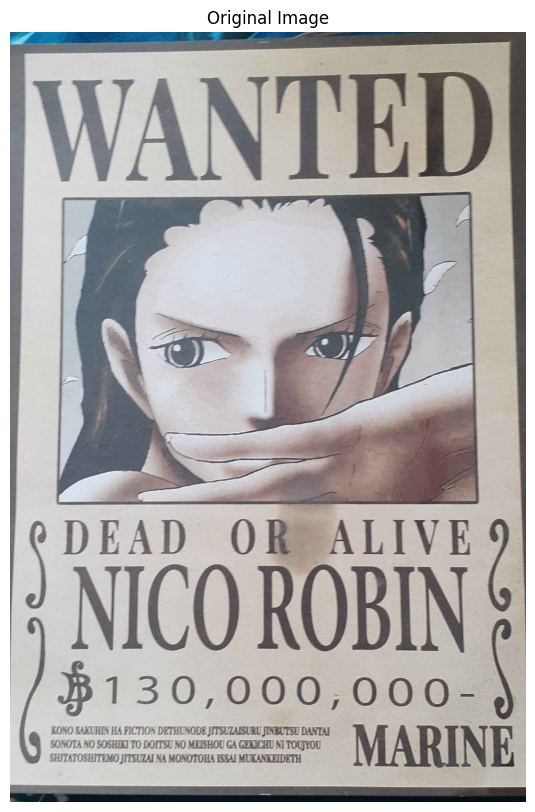

In [72]:
plt.figure(figsize=[20,10])
plt.subplot(121);plt.axis('off');plt.imshow(img1);plt.title('Original Image')